Installing two packages


In [ ]:
!pip install scikit-optimize
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 16.9 MB/s eta 0:00:00


Setting up all the imports needed

In [ ]:
import os
import zipfile
import json
import time
import joblib
import optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    ParameterGrid,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    brier_score_loss,
    average_precision_score,
    precision_recall_curve
)
from sklearn.calibration import calibration_curve
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from scipy.special import logit, expit
from scipy.sparse import hstack
from scipy.stats import spearmanr

from xgboost import XGBRegressor

from skopt import BayesSearchCV
from skopt.space import Integer, Real
from skopt.callbacks import DeadlineStopper
from scipy.special import expit
from optuna.samplers import TPESampler


### Define Constants and File Paths

This section defines the file paths for CVE datasets from both MITRE and NVD for the years 2022–2024, as well as the EPSS score archive. It sets global constants for the evaluation snapshot date, a random seed, and a runtime timeout. Before proceeding, the code verifies that all required data files are present in the working directory and prints the contents of the EPSS archive as a basic integrity check.

In [ ]:
ZIP22_MITRE = "CVES_2022.zip"
ZIP22_NVD   = "nvdcve-1.1-2022.zip"
ZIP23_MITRE = "CVES_2023.zip"
ZIP23_NVD   = "nvdcve-1.1-2023.zip"
ZIP24_MITRE = "CVES_2024.zip"
ZIP24_NVD   = "nvdcve-1.1-2024.zip"

EPSS_PATH = "all_epss_scores.zip"
with zipfile.ZipFile(EPSS_PATH) as z:
    print("Files in ZIP:", z.namelist())

SNAP_DATE = pd.Timestamp("2023-12-31", tz="UTC")
SEED      = 45
TIMEOUT   = 300         # timelimit

# ensure all required files are present
for p in (ZIP22_MITRE, ZIP22_NVD,cZIP23_MITRE, ZIP23_NVD, ZIP24_MITRE,
          ZIP24_NVD, EPSS_PATH):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Missing file: {p}")

global_start = time.perf_counter()

Files in ZIP: ['all_epss_scores.csv']


### Extract EPSS scores

This block extracts and loads EPSS scores from the `all_epss_scores.csv` file within the EPSS ZIP archive. It skips the two-line header, reads only the `cve` and `epss` columns, and filters the dataset to include only CVEs from the years 2022 to 2024. The number of filtered entries and loading time are printed for verification and debugging.

In [ ]:
t0 = time.perf_counter()

with zipfile.ZipFile(EPSS_PATH) as z:
    with z.open("all_epss_scores.csv") as f:
        epss_all = pd.read_csv(
            f,
            skiprows=2,
            header=None,
            names=["cve", "epss", "percentile"]
        )[["cve", "epss"]]

# Filter EPSS entries to only include CVEs from 2022 to 2024
epss_all = epss_all[epss_all["cve"].str.contains("CVE-202[2-4]-")]
print(f"[DEBUG] Filtered EPSS (2022–2024): {len(epss_all)} rows")

t1 = time.perf_counter()
print(f"[1] EPSS loaded ({len(epss_all):,} rows) in {t1 - t0:.1f}s")
print(f"Rows loaded: {len(epss_all):,}")
print(epss_all.head())

[DEBUG] Filtered EPSS (2022–2024): 91668 rows
[1] EPSS loaded (91,668 rows) in 0.6s
Rows loaded: 91,668
                  cve     epss
175156  CVE-2022-0001  0.00227
175157  CVE-2022-0002  0.00504
175158  CVE-2022-0004  0.00087
175159  CVE-2022-0005  0.00035
175160  CVE-2022-0010  0.00061


### Load and Merge CVE Records

Parses CVE metadata from a MITRE ZIP archive and enriches it with severity scores from an NVD ZIP archive and EPSS scores.

The function proceeds in three stages:
1. Lists the contents of the MITRE ZIP (for debugging purposes).
2. Loads all CVE entries from the NVD JSON file and creates a fast lookup table by CVE ID.
3. Iterates through each MITRE JSON file, extracting CVE metadata (ID, publication date, description, references, problem types) and CVSS v3 severity metrics from NVD if available.

After collecting all valid records, the function returns a merged `DataFrame` containing only CVEs with corresponding EPSS scores.

In [ ]:
def load_cves(mitre_zip_path, nvd_zip_path, epss_df):
    recs = []

    # Step 1: List MITRE ZIP contents (debug)
    with zipfile.ZipFile(mitre_zip_path) as mitre_zip:
        names = mitre_zip.namelist()
        print(f"[DEBUG] ZIP content in {mitre_zip_path} — total files: {len(names)}")
        for fn in names[:20]:
            print(f" - {fn}")

    # Step 2: Load NVD JSON from ZIP
    with zipfile.ZipFile(nvd_zip_path) as nvd_zip:
        with nvd_zip.open(nvd_zip.namelist()[0]) as f:
            nvd_data = json.load(f)
            nvd_lookup = {
                item["cve"]["CVE_data_meta"]["ID"]: item
                for item in nvd_data["CVE_Items"]
            }

    # Step 3: Iterate over MITRE JSON files inside the ZIP
    with zipfile.ZipFile(mitre_zip_path) as mitre_zip:
        for fn in mitre_zip.namelist():
            # Skip non-json and __MACOSX files
            if not fn.endswith(".json") or "__MACOSX" in fn:
                continue

            try:
                r = json.load(mitre_zip.open(fn))
                m = r.get("cveMetadata", {})
                pub = m.get("datePublished", "")
                if not pub:
                    continue

                dt = pd.to_datetime(pub, utc=True)
                cid = m.get("cveId", "")
                if not cid:
                    print(f"[WARN] No CVE ID in {fn}")
                    continue

                cna = r.get("containers", {}).get("cna", {})
                descs = cna.get("descriptions", [])
                desc = descs[0]["value"] if descs else ""
                refs = cna.get("references", [])
                ptypes = cna.get("problemTypes", [])

                # Add NVD info if available
                nvd = nvd_lookup.get(cid, {})
                impact = nvd.get("impact", {})
                cvss_v3 = impact.get("baseMetricV3", {}).get("cvssV3", {})
                score = cvss_v3.get("baseScore", None)
                severity = cvss_v3.get("baseSeverity", None)

                recs.append({
                    "cve": cid,
                    "pub_dt": dt,
                    "year": dt.year,
                    "desc": desc,
                    "desc_length": len(desc),
                    "ref_count": len(refs),
                    "cwe_count": sum(len(pt.get("descriptions", [])) for pt in ptypes),
                    "cvss_score": score,
                    "cvss_severity": severity,
                })

            except Exception as e:
                print(f"[ERROR] Failed to parse {fn}: {e}")

    print(f"[DEBUG] Loaded {len(recs)} CVEs from {mitre_zip_path}")
    df = pd.DataFrame(recs)

    if df.empty:
        print("[WARN] No CVEs collected — returning empty DataFrame")
        return pd.DataFrame()

    df_merged = df.merge(epss_df, on="cve", how="inner")
    print(f"[DEBUG] After EPSs merge: {len(df_merged)} records remain")
    return df_merged

### Prepare Training, Validation, and Test Sets from CVE Data

This section loads CVE records from 2022 and 2023, filters to the top 5% by EPSS score, and samples 2,700 high-risk CVEs for modeling. The data is split into training (80%) and validation (20%) subsets using a fixed seed for reproducibility. Separately, 2024 CVEs are loaded, filtered using the same top-5% EPSS threshold, and a test set is sampled to match 20% of the training set size. This approach ensures the model is trained and evaluated on high-severity, high-risk examples from recent years.

In [ ]:
# 1. Load all CVEs from 2020–2023
df22 = load_cves(ZIP22_MITRE, ZIP22_NVD, epss_all)
df23 = load_cves(ZIP23_MITRE, ZIP23_NVD, epss_all)

df_trainval_all = pd.concat([df22, df23], ignore_index=True)
print(f"Total training data (2020–2023): {len(df_trainval_all):,} CVEs")

# 2. Take top 5% by EPSS score
epss_cutoff = df_trainval_all["epss"].quantile(0.95)
df_top5 = df_trainval_all[df_trainval_all["epss"] >= epss_cutoff]
print(f"Top 5% data: {len(df_top5):,} CVEs with EPSS ≥ {epss_cutoff:.4f}")

# 3. Sample 2700 from top 5%
df_sampled = df_top5.sample(n=2700, random_state=SEED)
print("Sampled 2700 high-EPSS CVEs for modeling")

# 4. Split into train (80%) and val (20%)
df_train, df_val = train_test_split(df_sampled, test_size=0.2, random_state=SEED)
print(f"Train size: {len(df_train):,} | Validation size: {len(df_val):,}")

# 5. Load 2024 and sample test set (20% of training size)
df24 = load_cves(ZIP24_MITRE, ZIP24_NVD, epss_all)
test_size = int(len(df_train) * 0.20)
epss_cutoff_2024 = df24["epss"].quantile(0.95)
df_top5_2024 = df24[df24["epss"] >= epss_cutoff_2024]
df_test = df_top5_2024.sample(n=test_size, random_state=SEED)
print(f"Test size: {len(df_test):,} sampled from 2024 CVEs")


[DEBUG] ZIP content in CVES_2022.zip — total files: 26445
 - 2022/
 - 2022/0xxx/
 - 2022/0xxx/CVE-2022-0001.json
 - 2022/0xxx/CVE-2022-0002.json
 - 2022/0xxx/CVE-2022-0003.json
 - 2022/0xxx/CVE-2022-0004.json
 - 2022/0xxx/CVE-2022-0005.json
 - 2022/0xxx/CVE-2022-0010.json
 - 2022/0xxx/CVE-2022-0011.json
 - 2022/0xxx/CVE-2022-0012.json
 - 2022/0xxx/CVE-2022-0013.json
 - 2022/0xxx/CVE-2022-0014.json
 - 2022/0xxx/CVE-2022-0015.json
 - 2022/0xxx/CVE-2022-0016.json
 - 2022/0xxx/CVE-2022-0017.json
 - 2022/0xxx/CVE-2022-0018.json
 - 2022/0xxx/CVE-2022-0019.json
 - 2022/0xxx/CVE-2022-0020.json
 - 2022/0xxx/CVE-2022-0021.json
 - 2022/0xxx/CVE-2022-0022.json
[DEBUG] Loaded 25613 CVEs from CVES_2022.zip
[DEBUG] After EPSs merge: 25375 records remain
[DEBUG] ZIP content in CVES_2023.zip — total files: 29779
 - 2023/
 - 2023/0xxx/
 - 2023/0xxx/CVE-2023-0001.json
 - 2023/0xxx/CVE-2023-0002.json
 - 2023/0xxx/CVE-2023-0003.json
 - 2023/0xxx/CVE-2023-0004.json
 - 2023/0xxx/CVE-2023-0005.json
 - 2023/0x

### Featurize CVE Records and Prepare Inputs for Modeling

This section prepares the CVE data for regression modeling by constructing both numerical and textual features. A new column, `days_since`, is computed to capture how many days have passed since each CVE's publication relative to a fixed snapshot date. For textual information, a TF-IDF vectorizer is fit on the CVE descriptions from the training set and then applied across all splits. This ensures that only training data informs the vocabulary, preventing any leakage from validation or test data.

Alongside text features, several numeric features are extracted, including the CVE's year, description length, number of references, number of CWEs, and days since publication. These are concatenated with the TF-IDF vectors to form a combined sparse feature matrix for each split.

The EPSS scores—originally in the \([0,1]\) probability range—are transformed into log-odds via the `logit` function to provide an unbounded target suitable for regression. Finally, the feature matrices are standardized using `StandardScaler` (with `with_mean=False` to accommodate sparse inputs), and both the vectorizer and scaler are saved to disk for reuse.



In [ ]:
t0 = time.perf_counter()
for d in (df_train, df_val, df_test):
    d["days_since"] = (SNAP_DATE - d["pub_dt"]).dt.days


tfidf = TfidfVectorizer(max_features=100, stop_words="english")
tfidf.fit(df_train["desc"])
joblib.dump(tfidf, "tfidf_reg_bayes_tamed_timed.joblib")

num_cols = ["year","desc_length","ref_count","cwe_count","days_since"]
def build_X_y(df):
    Xn = df[num_cols].values
    Xt = tfidf.transform(df["desc"])
    X  = hstack([Xn, Xt])
    # Transform EPSS from [0,1] probability to log-odds (logit) scale for regression
    y  = logit(df["epss"].clip(1e-6, 1-1e-6))
    return X, y

X_tr, y_tr   = build_X_y(df_train)
X_val, y_val = build_X_y(df_val)
X_te, y_te   = build_X_y(df_test)
print(f" df_test: {df_test}")


scaler = StandardScaler(with_mean=False).fit(X_tr)
X_tr_s = scaler.transform(X_tr)
X_val_s= scaler.transform(X_val)
X_te_s = scaler.transform(X_te)
joblib.dump(scaler, "scaler_reg_bayes_tamed_timed.joblib")

t1 = time.perf_counter()
print(f"[4] Featurization + scaling in {t1-t0:.1f}s")

 df_test:                   cve                           pub_dt  year  \
11382  CVE-2024-28991 2024-09-12 13:17:30.721000+00:00  2024   
21774  CVE-2024-41874 2024-09-13 09:18:03.226000+00:00  2024   
8207   CVE-2024-23998        2024-07-05 00:00:00+00:00  2024   
14313  CVE-2024-32136 2024-04-15 07:29:56.639000+00:00  2024   
16140  CVE-2024-34784 2024-11-13 01:54:45.555000+00:00  2024   
...               ...                              ...   ...   
19228  CVE-2024-39250        2024-07-22 00:00:00+00:00  2024   
22156  CVE-2024-42323 2024-09-21 09:30:15.295000+00:00  2024   
11427  CVE-2024-29043 2024-04-09 17:00:30.944000+00:00  2024   
3701   CVE-2024-13160 2025-01-14 17:12:23.237000+00:00  2025   
6367   CVE-2024-21320 2024-01-09 17:57:12.919000+00:00  2024   

                                                    desc  desc_length  \
11382  SolarWinds Access Rights Manager (ARM) was fou...          233   
21774  ColdFusion versions 2023.9, 2021.15 and earlie...          412   
82

### Run Bayesian Optimization for XGBoost Hyperparameter Tuning

This block performs hyperparameter tuning for an XGBoost regression model using Bayesian optimization via `BayesSearchCV`. A search space is defined over key XGBoost parameters such as tree depth, learning rate, regularization strength, and subsampling rates. The optimizer is configured to run for up to 50 iterations, using 5-fold cross-validation and negative mean squared error as the scoring metric.

To keep optimization time bounded, a `DeadlineStopper` is used to enforce a strict timeout limit. The training data (`X_tr_s`, `y_tr`) is passed to the optimizer, which iteratively selects and evaluates hyperparameter configurations based on previous results. Once finished, the best parameters and the corresponding fitted model are extracted for use in downstream evaluation.

In [ ]:
search_spaces = {
    "max_depth":         Integer(2, 6),
    "learning_rate":     Real(0.1, 0.5, prior="uniform"),
    "gamma":             Real(0, 5, prior="uniform"),
    "reg_lambda":        Real(0, 5, prior="uniform"),
    "reg_alpha":         Real(0, 2, prior="uniform"),
    "subsample":         Real(0.7, 1.0, prior="uniform"),
    "colsample_bytree":  Real(0.7, 1.0, prior="uniform")
}

print("[Bayes] Starting BayesSearchCV ...")
start_time = time.perf_counter()

bayes = BayesSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=SEED),
    search_spaces=search_spaces,
    n_iter=50,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=SEED,
    verbose=0,
    return_train_score=True
)

stopper = DeadlineStopper(total_time=TIMEOUT)
bayes.fit(X_tr_s, y_tr, callback=[stopper])

elapsed_time_bayes = time.perf_counter() - start_time

print(f"[Bayes] Done in {elapsed_time_bayes:.1f}s")
best_bayes_params = bayes.best_params_
best_bayes_model = bayes.best_estimator_


[Bayes] Starting BayesSearchCV ...
[Bayes] Done in 224.9s


### Manual Grid Search for Hyperparameter Tuning of XGBoost Regressor with Timeout

This code block performs a manual grid search over a specified hyperparameter grid for an XGBoost regression model (XGBRegressor). It evaluates combinations of parameters such as max_depth, learning_rate, gamma, reg_lambda, reg_alpha, subsample, and colsample_bytree using 5-fold cross-validation based on the negative mean squared error metric. The search is time-limited by a defined TIMEOUT to prevent long-running computations. Throughout the process, progress and intermediate results are printed. Once the best parameter set is found within the time constraint, the model is retrained on the full training data using those optimal hyperparameters.

In [ ]:
param_grid = {
    "max_depth":         [2, 4, 6],
    "learning_rate":     [0.1, 0.3, 0.5],
    "gamma":             [0, 2.5, 5],
    "reg_lambda":        [0, 2.5, 5],
    "reg_alpha":         [0, 1, 2],
    "subsample":         [0.7, 0.85, 1.0],
    "colsample_bytree":  [0.7, 0.85, 1.0]
}

print("[Grid] Starting manual grid search with timeout of {} seconds...".format(TIMEOUT))

start_time = time.perf_counter()
best_score = -np.inf
best_params = None

all_params = list(ParameterGrid(param_grid))
total_combinations = len(all_params)

for idx, params in enumerate(all_params, start=1):
    elapsed_time = time.perf_counter() - start_time

    if elapsed_time > TIMEOUT:
        print(f"    ⏱ Time limit reached ({elapsed_time:.0f}s); stopping grid search.")
        break

    model = XGBRegressor(objective="reg:squarederror", random_state=SEED, **params)
    scores = cross_val_score(
        model,
        X_tr_s, y_tr,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=0
    )

    mean_score = np.mean(scores)
    print(f"    {idx:4d}/{total_combinations:4d} params={params} → mean neg_MSE={mean_score:.4f} (elapsed {elapsed_time:.0f}s)")

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

elapsed_time_grid = time.perf_counter() - start_time
print(f"[Grid] Search done in {elapsed_time_grid:.0f}s; best_params={best_params}")

best_grid_model = XGBRegressor(objective="reg:squarederror", random_state=SEED, **best_params)
best_grid_model.fit(X_tr_s, y_tr)


[Grid] Starting manual grid search with timeout of 300 seconds...
       1/2187 params={'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.7} → mean neg_MSE=-2.6336 (elapsed 0s)
       2/2187 params={'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.85} → mean neg_MSE=-2.6024 (elapsed 1s)
       3/2187 params={'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1.0} → mean neg_MSE=-2.6272 (elapsed 2s)
       4/2187 params={'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'reg_alpha': 0, 'reg_lambda': 2.5, 'subsample': 0.7} → mean neg_MSE=-2.6220 (elapsed 2s)
       5/2187 params={'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'reg_alpha': 0, 'reg_lambda': 2.5, 'subsample': 0.85} → mean neg_MSE=-2.6057 (elapsed 3s)
       6

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=45, ...)

### Hyperparameter Optimization of XGBoost Regressor Using TPE (Tree-structured Parzen Estimator)

This code performs hyperparameter tuning for an XGBRegressor using Optuna’s TPE sampler, which is a Bayesian optimization method. It defines an objective function that suggests values for key model hyperparameters such as n_estimators, max_depth, learning_rate, subsample, colsample_bytree, reg_alpha, reg_lambda, and gamma. The model is evaluated with 5-fold cross-validation using mean squared error as the metric. The optimization runs with a time limit (TIMEOUT) and up to 50 trials, leveraging a progress bar for tracking. After finding the best hyperparameters, the model is retrained on the full training set with the optimized parameters.

In [ ]:
print("\n[5-TPE] Starting TPE hyperparameter optimization...")

y_tr = y_tr.reset_index(drop=True)

def objective(trial):
    params = {
        "n_estimators":     trial.suggest_int("n_estimators", 50, 300),
        "max_depth":        trial.suggest_int("max_depth", 2, 6),
        "learning_rate":    trial.suggest_float("learning_rate", 0.1, 0.5),
        "subsample":        trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha":        trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda":       trial.suggest_float("reg_lambda", 0.0, 5.0),
        "gamma":            trial.suggest_float("gamma", 0.0, 5.0),
        "random_state":     SEED,
        "objective":        "reg:squarederror"
    }

    model = XGBRegressor(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    val_scores = []

    for train_idx, valid_idx in cv.split(X_tr_s):
        model.fit(X_tr_s[train_idx], y_tr[train_idx])
        preds = model.predict(X_tr_s[valid_idx])
        val_scores.append(mean_squared_error(y_tr[valid_idx], preds))

    return np.mean(val_scores)

tpe_start = time.perf_counter()

study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=SEED))
study.optimize(objective, timeout=TIMEOUT, n_trials=50, show_progress_bar=True)

tpe_end = time.perf_counter()
elapsed_time_tpe = tpe_end - tpe_start

print(f"[5-TPE] TPE optimization finished in {elapsed_time_tpe:.1f}s")
print(f"[5-TPE] Best hyperparameters found: {study.best_params}")

tpe_model = XGBRegressor(**study.best_params)
tpe_model.fit(X_tr_s, y_tr)


[I 2025-07-01 22:56:30,772] A new study created in memory with name: no-name-c6502e6c-7d57-4cf3-80fd-c9141f59cc40



[5-TPE] Starting TPE hyperparameter optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-01 22:56:38,959] Trial 0 finished with value: 2.82587705075042 and parameters: {'n_estimators': 298, 'max_depth': 4, 'learning_rate': 0.21257892078202514, 'subsample': 0.7231868698237518, 'colsample_bytree': 0.8333408487915409, 'reg_alpha': 0.9456159395109707, 'reg_lambda': 0.24261000453222936, 'gamma': 0.8166222410413337}. Best is trial 0 with value: 2.82587705075042.
[I 2025-07-01 22:56:44,310] Trial 1 finished with value: 2.855008648553578 and parameters: {'n_estimators': 79, 'max_depth': 5, 'learning_rate': 0.4424728194382498, 'subsample': 0.8950307263262658, 'colsample_bytree': 0.9972165054273401, 'reg_alpha': 0.9407014968075709, 'reg_lambda': 3.091472417836791, 'gamma': 1.4133360326558368}. Best is trial 0 with value: 2.82587705075042.
[I 2025-07-01 22:56:49,926] Trial 2 finished with value: 2.838244541698366 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.2762123555098178, 'subsample': 0.7869062020756284, 'colsample_bytree': 0.8529099052141423

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7740260864740852, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=4.347570085155284,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.10297426960998585,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=95, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Comprehensive Model Evaluation and Visualization for Multiple XGBoost Models

This code block evaluates, compares, and visualizes the performance of several trained XGBoost models (best_bayes_model, best_grid_model, tpe_model) on different datasets: training, validation, and test sets.

Evaluation Metrics:
It defines an evaluate_model function to compute MSE, MAE, and R² scores, converting model outputs from logits to probabilities if needed.
It then compiles results for each model and dataset into a Pandas DataFrame with a MultiIndex, including training time for each model.

Output:
The results table is printed and saved to CSV.
Training times are visualized via a bar plot and saved as an image.

Real-Scale Evaluation on Test Set:
For the 2024 test dataset, predictions are transformed back to the original EPSS scale, and metrics plus Pearson correlation are calculated and displayed.
Actual vs predicted EPSS values are saved, and scatter plots comparing these values are generated and saved for each model.

Additional Visualization:
Histograms show the distribution of EPSS values in both training and test datasets to give context on the target variable’s spread.

This workflow provides a thorough performance summary, enabling easy comparison of models across multiple datasets and facilitating deeper insight through visualizations and saved reports.


=== Model Evaluation Metrics ===
                       MSE       MAE        R2    Time (s)
Model    Dataset                                          
Bayesian TRAIN    0.048107  0.178792   0.51734  224.937442
         VAL      0.082669  0.237544  0.165295            
         TEST     0.084467  0.249727  0.081034            
Grid     TRAIN    0.033299   0.14461  0.665909  301.537955
         VAL      0.087372  0.241331  0.117812            
         TEST     0.081544   0.24067  0.112838            
TPE      TRAIN    0.046411  0.176519  0.534364  215.840428
         VAL      0.085167  0.242322  0.140072            
         TEST     0.085364  0.247957  0.071274            
Saved model evaluation metrics to 'model_evaluation_metrics.csv'


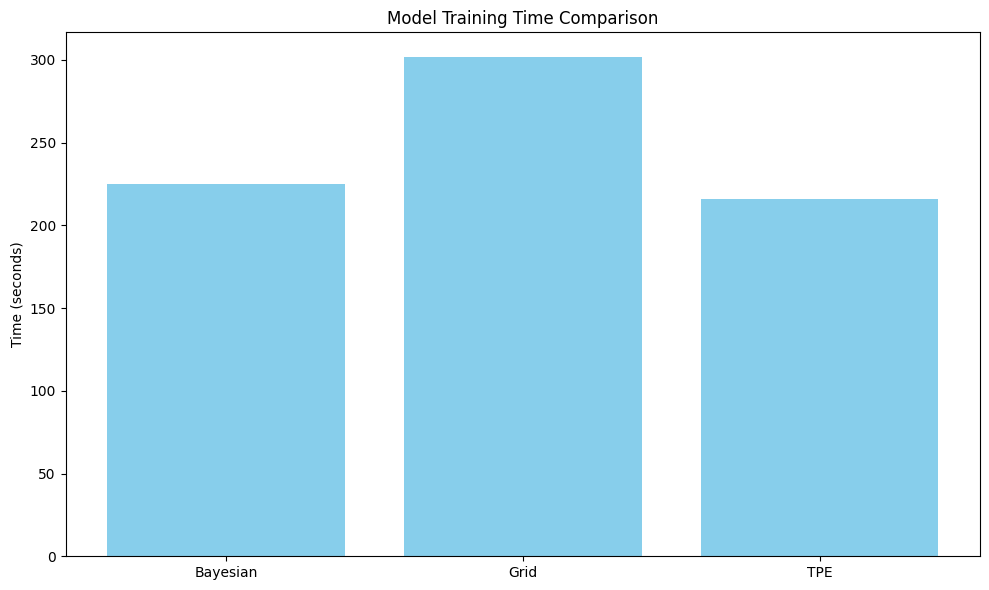

Saved training time comparison plot to 'model_training_time_comparison.png'

=== Real Scale Evaluation on TEST Set (2024) ===

[Bayesian Model — Real EPSS Comparison]
MSE: 0.084467
MAE: 0.249727
Pearson Correlation: 0.3549
Saved real vs predicted EPSS to 'bayesian_real_vs_predicted_epss.csv'


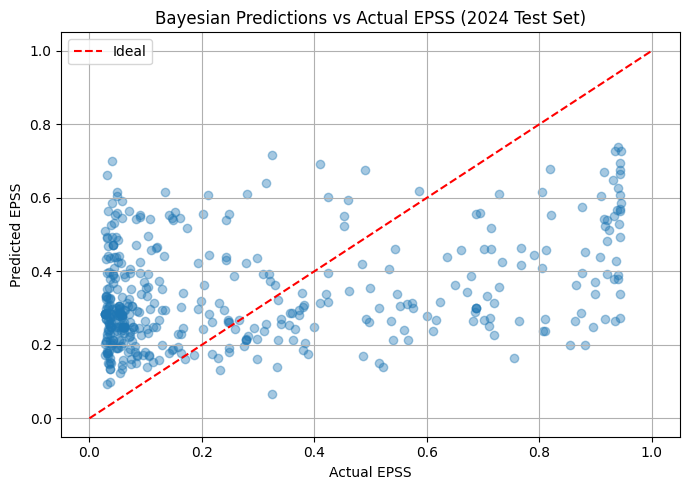

Saved scatter plot to 'bayesian_epss_scatter.png'

[Grid Model — Real EPSS Comparison]
MSE: 0.081544
MAE: 0.240670
Pearson Correlation: 0.3649
Saved real vs predicted EPSS to 'grid_real_vs_predicted_epss.csv'


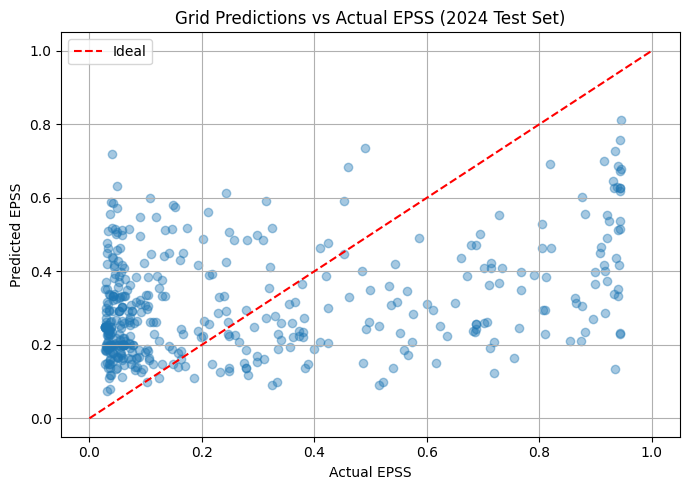

Saved scatter plot to 'grid_epss_scatter.png'

[TPE Model — Real EPSS Comparison]
MSE: 0.085364
MAE: 0.247957
Pearson Correlation: 0.3228
Saved real vs predicted EPSS to 'tpe_real_vs_predicted_epss.csv'


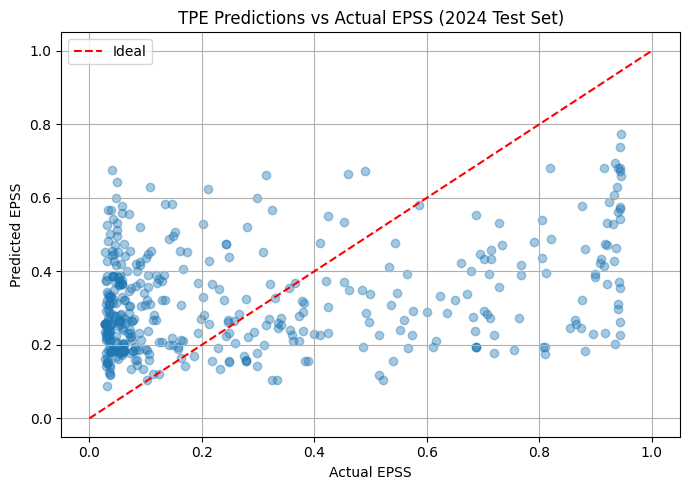

Saved scatter plot to 'tpe_epss_scatter.png'


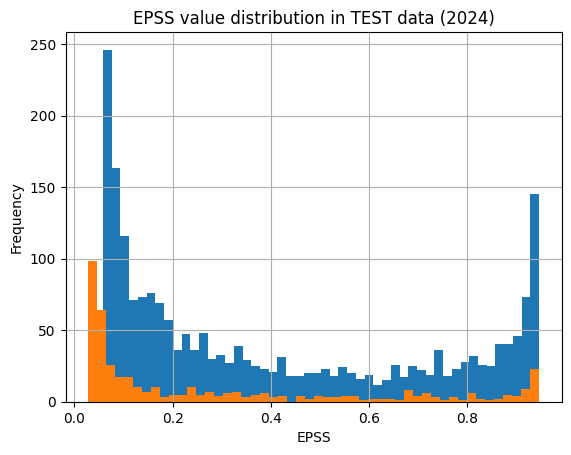

0.0282

In [ ]:
def evaluate_model(y_true, y_pred_logits):
    # Convert model's logit predictions back to probability space
    y_pred = expit(y_pred_logits)
    y_true_real = expit(y_true) if np.max(y_true) > 1.0 else y_true
    mse = mean_squared_error(y_true_real, y_pred)
    mae = mean_absolute_error(y_true_real, y_pred)
    r2 = r2_score(y_true_real, y_pred)
    return mse, mae, r2

models_ran = []
elapsed_times = []
results = []

datasets = {
    "TRAIN": (X_tr_s, y_tr),
    "VAL": (X_val_s, y_val),
    "TEST": (X_te_s, y_te),
}

# Check which models exist
if 'best_bayes_model' in globals():
    models_ran.append("Bayesian")
    elapsed_times.append(elapsed_time_bayes if 'elapsed_time_bayes' in globals() else np.nan)

if 'best_grid_model' in globals():
    models_ran.append("Grid")
    elapsed_times.append(elapsed_time_grid if 'elapsed_time_grid' in globals() else np.nan)

if 'tpe_model' in globals():
    models_ran.append("TPE")
    elapsed_times.append(elapsed_time_tpe if 'elapsed_time_tpe' in globals() else np.nan)

# Create MultiIndex for model/dataset performance
index = pd.MultiIndex.from_product([models_ran, datasets.keys()], names=["Model", "Dataset"])
df_results = pd.DataFrame(index=index, columns=["MSE", "MAE", "R2", "Time (s)"])

# Fill in evaluation metrics
for model in models_ran:
    model_obj = None
    if model == "Bayesian":
        model_obj = best_bayes_model
    elif model == "Grid":
        model_obj = best_grid_model
    elif model == "TPE":
        model_obj = tpe_model

    for dataset_name, (X_data, y_true) in datasets.items():
        y_pred = model_obj.predict(X_data)
        mse, mae, r2 = evaluate_model(y_true, y_pred)

        df_results.loc[(model, dataset_name), "MSE"] = mse
        df_results.loc[(model, dataset_name), "MAE"] = mae
        df_results.loc[(model, dataset_name), "R2"] = r2
        if dataset_name == "TRAIN":
            df_results.loc[(model, dataset_name), "Time (s)"] = elapsed_times[models_ran.index(model)]
        else:
            df_results.loc[(model, dataset_name), "Time (s)"] = ""

print("\n=== Model Evaluation Metrics ===")
print(df_results)

# Save results to CSV
df_results.to_csv("model_evaluation_metrics.csv")
print("Saved model evaluation metrics to 'model_evaluation_metrics.csv'")

# Bar plot: training times
plt.figure(figsize=(10, 6))
plt.bar(models_ran, elapsed_times, color='skyblue')
plt.ylabel("Time (seconds)")
plt.title("Model Training Time Comparison")
plt.tight_layout()
plt.savefig("model_training_time_comparison.png")
plt.show()
print("Saved training time comparison plot to 'model_training_time_comparison.png'")

# Real Scale Evaluation on TEST Set
print("\n=== Real Scale Evaluation on TEST Set (2024) ===")
y_true_epss = df_test["epss"].values

for model in models_ran:
    if model == "Bayesian":
        model_obj = best_bayes_model
    elif model == "Grid":
        model_obj = best_grid_model
    elif model == "TPE":
        model_obj = tpe_model
    else:
        continue

    y_pred_logits = model_obj.predict(X_te_s)
    y_pred_epss = expit(y_pred_logits)

    mse_real = mean_squared_error(y_true_epss, y_pred_epss)
    mae_real = mean_absolute_error(y_true_epss, y_pred_epss)
    r2_real = r2_score(y_true_epss, y_pred_epss)
    corr = np.corrcoef(y_true_epss, y_pred_epss)[0, 1]

    print(f"\n[{model} Model — Real EPSS Comparison]")
    print(f"MSE: {mse_real:.6f}")
    print(f"MAE: {mae_real:.6f}")
    print(f"Pearson Correlation: {corr:.4f}")

    # Save actual vs predicted values
    results_df = pd.DataFrame({
        "actual_epss": y_true_epss,
        "predicted_epss": y_pred_epss
    })
    results_df.to_csv(f"{model.lower()}_real_vs_predicted_epss.csv", index=False)
    print(f"Saved real vs predicted EPSS to '{model.lower()}_real_vs_predicted_epss.csv'")

    # Scatter plot: actual vs predicted EPSS
    plt.figure(figsize=(7, 5))
    plt.scatter(y_true_epss, y_pred_epss, alpha=0.4)
    plt.plot([0, 1], [0, 1], 'r--', label="Ideal")
    plt.xlabel("Actual EPSS")
    plt.ylabel("Predicted EPSS")
    plt.title(f"{model} Predictions vs Actual EPSS (2024 Test Set)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{model.lower()}_epss_scatter.png")
    plt.show()
    print(f"Saved scatter plot to '{model.lower()}_epss_scatter.png'")

    import matplotlib.pyplot as plt
plt.hist(df_train["epss"], bins=50)
plt.title("EPSS value distribution in training data")

plt.hist(df_test["epss"], bins=50)
plt.title("EPSS value distribution in TEST data (2024)")
plt.xlabel("EPSS")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

df_test["epss"].min()


### Exploring EPSS Score Distributions Across Training, Validation, and Test Sets

This section provides a comprehensive statistical overview and visualization of the EPSS (Exploit Prediction Scoring System) scores across the training, validation, and test datasets. It begins by printing descriptive statistics for each dataset to summarize key distributional properties such as mean, median, and quartiles. These statistics are then consolidated into a single DataFrame, transposed for clarity, rounded for readability, and saved as a CSV file for further reference and reporting.

To visually compare the EPSS distributions, overlaid histograms display the score frequencies across all three datasets, highlighting differences and similarities in their distributions. A dedicated histogram focuses on the test set’s 2024 data, providing a detailed view of its EPSS score spread. The unique counts of CVEs within each dataset are also reported to contextualize the scope of the data involved.

Further analysis explores the distribution of EPSS scores within the combined training and validation data by calculating key quantiles—specifically, the 75th and 95th percentiles—to isolate the top 25% and top 5% of vulnerabilities by risk score. Separate histograms with kernel density estimates illustrate the distribution of EPSS scores for the full dataset as well as these high-risk subsets. Each plot is clearly titled, saved, and formatted to support a nuanced understanding of how the scores are distributed across different risk strata, thereby enhancing insight into the data’s behavior and informing downstream modeling or decision-making efforts.

Training Set EPSS Statistics:
count    2160.000000
mean        0.408546
std         0.315781
min         0.058330
25%         0.114720
50%         0.296180
75%         0.724158
max         0.945840
Name: epss, dtype: float64

Validation Set EPSS Statistics:
count    540.000000
mean       0.387852
std        0.314998
min        0.058710
25%        0.114280
50%        0.242845
75%        0.704545
max        0.944850
Name: epss, dtype: float64

Test Set EPSS Statistics:
count    432.000000
mean       0.280131
std        0.303527
min        0.028200
25%        0.049338
50%        0.108505
75%        0.454965
max        0.945790
Name: epss, dtype: float64


Saved EPSS summary statistics to 'epss_summary_statistics.csv'
              count    mean     std     min     25%     50%     75%     max
Train        2160.0  0.4085  0.3158  0.0583  0.1147  0.2962  0.7242  0.9458
Validation    540.0  0.3879  0.3150  0.0587  0.1143  0.2428  0.7045  0.9448
Test (2024)   432.0  0.2801  0.3035  0.0282  0.0

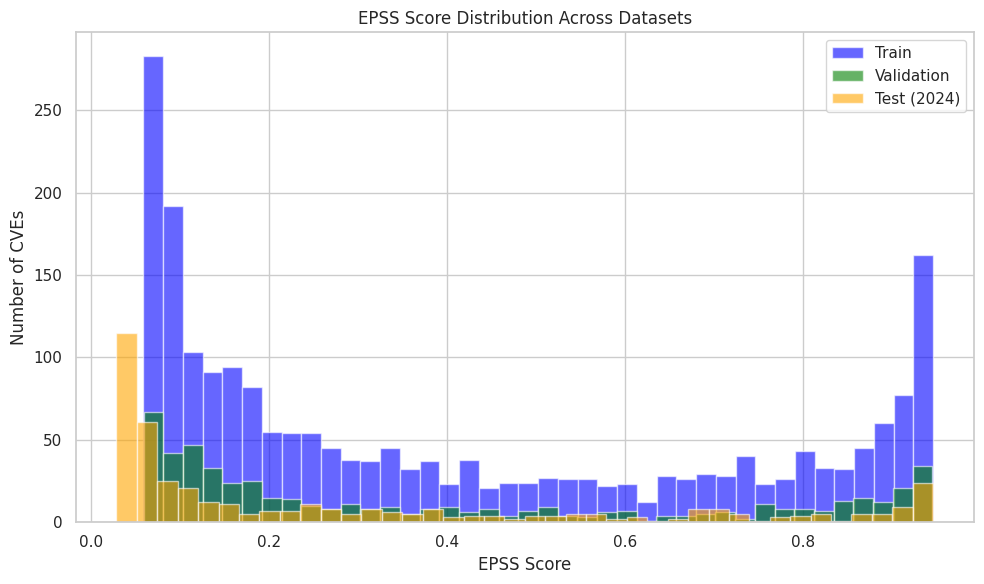

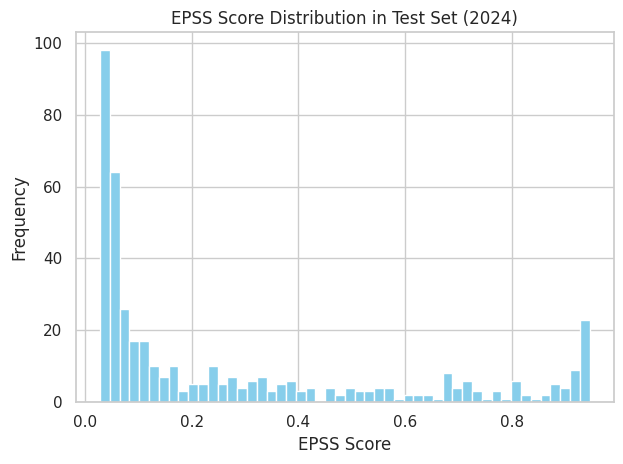

Training CVEs: 2160
Validation CVEs: 540
Test CVEs (2024): 432


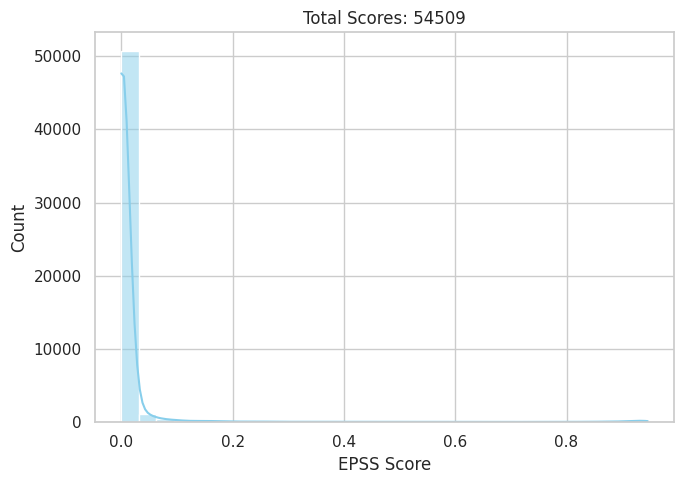

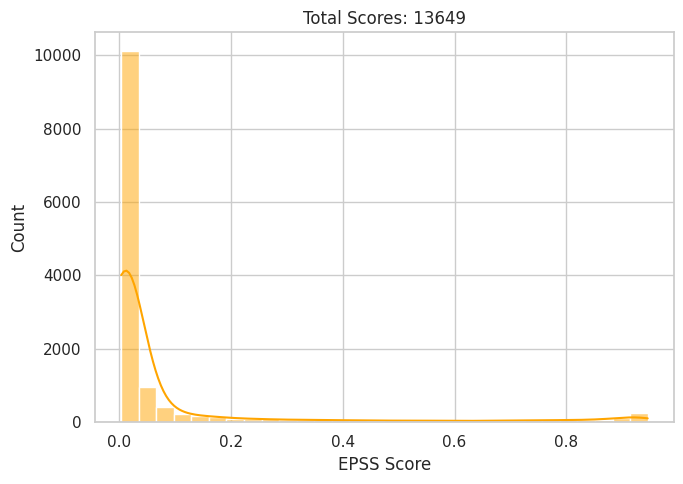

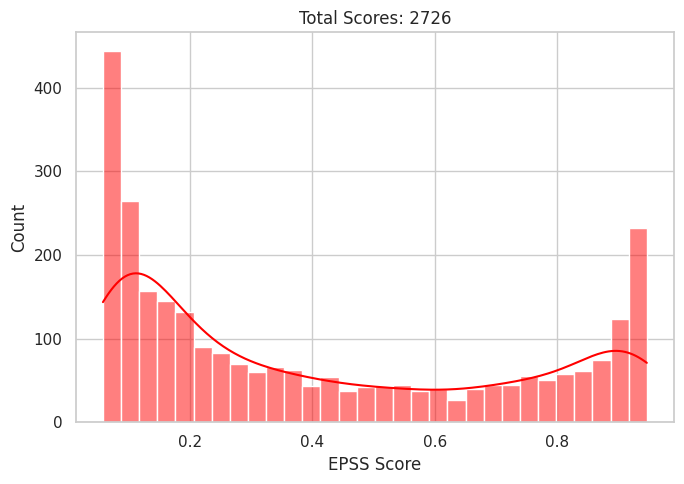

In [ ]:
print("Training Set EPSS Statistics:")
print(df_train["epss"].describe())

print("\nValidation Set EPSS Statistics:")
print(df_val["epss"].describe())

print("\nTest Set EPSS Statistics:")
print(df_test["epss"].describe())
print("\n")

# Compute basic EPSS statistics for each dataset
stats = {
    "Train": df_train["epss"].describe(),
    "Validation": df_val["epss"].describe(),
    "Test (2024)": df_test["epss"].describe()
}

# Convert to a DataFrame
df_epss_stats = pd.DataFrame(stats)

# Transpose to make datasets rows and statistics columns
df_epss_stats = df_epss_stats.T

# Round for readability
df_epss_stats = df_epss_stats.round(4)

# Save to CSV
df_epss_stats.to_csv("epss_summary_statistics.csv")

# Show it
print("Saved EPSS summary statistics to 'epss_summary_statistics.csv'")
print(df_epss_stats)

plt.figure(figsize=(10, 6))
plt.hist(df_train["epss"], bins=40, alpha=0.6, label="Train", color='blue')
plt.hist(df_val["epss"], bins=40, alpha=0.6, label="Validation", color='green')
plt.hist(df_test["epss"], bins=40, alpha=0.6, label="Test (2024)", color='orange')
plt.xlabel("EPSS Score")
plt.ylabel("Number of CVEs")
plt.title("EPSS Score Distribution Across Datasets")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("epss_distribution_all_datasets.png")
plt.show()

plt.hist(df_test["epss"], bins=50, color='skyblue')
plt.title("EPSS Score Distribution in Test Set (2024)")
plt.xlabel("EPSS Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("epss_distribution_test_2024.png")
plt.show()

print(f"Training CVEs: {df_train['cve'].nunique()}")
print(f"Validation CVEs: {df_val['cve'].nunique()}")
print(f"Test CVEs (2024): {df_test['cve'].nunique()}")

# Ensure EPS values are in a numpy array
epss_values = df_trainval_all["epss"].values

# Compute 25% and 5% quantile thresholds
q25 = np.quantile(epss_values, 0.75)
q95 = np.quantile(epss_values, 0.95)

# Create datasets
df_100 = df_trainval_all.copy()
df_25 = df_trainval_all[df_trainval_all["epss"] >= q25]
df_5  = df_trainval_all[df_trainval_all["epss"] >= q95]

# Dataset info for captions
total_scores_100 = len(df_100)
total_scores_25 = len(df_25)
total_scores_5 = len(df_5)

sns.set(style="whitegrid")

# --- Plot 1: Full dataset ---
plt.figure(figsize=(7, 5))
sns.histplot(df_100["epss"], kde=True, bins=30, color="skyblue")
plt.title(f"Total Scores: {total_scores_100}")
plt.xlabel("EPSS Score")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("epss_distribution_full_dataset.png")
plt.show()

# --- Plot 2: Top 25% ---
plt.figure(figsize=(7, 5))
sns.histplot(df_25["epss"], kde=True, bins=30, color="orange")
plt.title(f"Total Scores: {total_scores_25}")
plt.xlabel("EPSS Score")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("epss_distribution_top_25_percent.png")
plt.show()

# --- Plot 3: Top 5% ---
plt.figure(figsize=(7, 5))
sns.histplot(df_5["epss"], kde=True, bins=30, color="red")
plt.title(f"Total Scores: {total_scores_5}")
plt.xlabel("EPSS Score")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("epss_distribution_top_5_percent.png")
plt.show()